# Deep Learning Model for Customer Churn Prediction

In this analysis, we utilize a shallow artificial neural network to predict customer churn. Our model architecture consists of:

- **Two Hidden Layers**: Each layer is fully connected and contains 50 neurons. They employ the ReLU (Rectified Linear Unit) activation function, a common choice for introducing non-linearity.
  
- **Output Layer**: This layer is equipped with a single neuron using a sigmoid activation function. Given the sigmoid's output range between 0 and 1, it's ideal for binary classification tasks.

- **Optimization**: We employ the **Adam optimizer** which merges the strengths of AdaGrad and RMSProp.
  
- **binary_crossentropy** – a standard choice of loss for binary classification challenges.

To gauge the efficacy of our model, we measure its performance using the **Area Under the Curve (AUC)** metric. This metric assesses the model's proficiency in distinguishing between the two classes. The model trains with provisions for early stopping and handling class imbalances.

## Why Transformer-based Models Might Not Be Ideal for Customer Churn Prediction

### 1. **No Need for Positional Embeddings**:
Transformers gained popularity primarily due to their ability to handle sequence data, especially in natural language processing tasks. One key component of transformers is the positional embedding, which keeps track of the position of each token in a sequence.

For customer churn prediction, we're dealing with structured tabular data where the position or order of columns doesn't inherently carry meaning. Thus, positional embeddings, one of the crucial features of transformers, become redundant in this context.

### 2. **Complexity**:
Transformer architectures, especially ones like BERT or GPT, are complex and have millions of parameters. Training such models on tabular data is not only be overkill but could also lead to overfitting, especially if the dataset isn't large enough like this.

### 3. **Interpretability**:
Business tasks like churn prediction benefit from models that offer interpretability. Stakeholders would want to understand which features are driving the predictions. Traditional models like decision trees or logistic regression or randomforest offer better interpretability. Transformer models, being more complex, can make it difficult to interpret and justify results.

Due to these reasons, we skip using an attention based model for our purpose and proceed with a shallow ANN.

In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [358]:
# Reproducability
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.utils.set_random_seed(0)
tf.random.set_seed(1234)
tf.config.experimental.enable_op_determinism()
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Constants
DIR = "/home/ananyapam/Projects/Customer-Churn-Prediction-IIITD"
DATA_PATH = f"{DIR}/data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
PREDICTOR_COLUMNS = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "tenure", 
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", 
    "MonthlyCharges", "TotalCharges"
]
TARGET_COLUMN = 'Churn'
factor_columns = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]
numeric_columns = ["tenure", "MonthlyCharges", "TotalCharges"]

In [359]:
def compute_class_weights(data):
    """
    Compute class weights based on data.
    """
    weight_for_0 = 1 / np.sum(data == 0)
    weight_for_1 = (1 / np.sum(data == 1))
    return {
        0: weight_for_0,
        1: weight_for_1
    }

def build_model(input_shape):
    """
    Build and return the sequential model.
    """
    #model = keras.Sequential()
    #model.add(layers.Dense(64, input_dim=input_shape, activation='relu'))
    #model.add(layers.Dense(32, activation='relu'))
    #model.add(layers.Dense(8, activation='relu'))
    #model.add(layers.Dense(1, activation='sigmoid'))
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

def plot_history(history):
    plt.figure(figsize=(20, 5))

    # Plot training & validation loss values
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation precision values
    plt.subplot(1, 3, 2)
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation recall values
    plt.subplot(1, 3, 3)
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [360]:
def load_data(path):
    """
    Load dataset from the specified path.

    Parameters:
    - path (str): Path to the dataset.

    Returns:
    - DataFrame: Loaded dataset.
    """
    return pd.read_csv(path)

def impute_total_charges(churn_df):
    """
    Handle missing values in the TotalCharges column.

    Parameters:
    - churn_df (DataFrame): The dataset.

    Returns:
    - DataFrame: Dataset with imputed values in the TotalCharges column.
    """
    churn_df['TotalCharges'] = churn_df['TotalCharges'].replace(' ', np.NaN)
    churn_df['TotalCharges'] = churn_df['TotalCharges'].astype(float)
    churn_df.loc[churn_df['TotalCharges'].isna(), 'TotalCharges'] = churn_df.loc[churn_df['TotalCharges'].isna(), 'MonthlyCharges']
    return churn_df

def manipulate_columns(churn_df):
    """
    Perform various column manipulations including handling missing values, encoding, and more.

    Parameters:
    - churn_df (DataFrame): The dataset.

    Returns:
    - DataFrame: Modified dataset.
    """
    # Manipulate the SeniorCitizen column
    churn_df['SeniorCitizen'] = churn_df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})
    
    # Merge the 'No Service' and 'No' counts for various columns
    columns_to_merge = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in columns_to_merge:
        churn_df[col] = churn_df[col].replace(['No phone service', 'No internet service'], 'No')
    
    # Encode binary columns
    binary_columns = ['gender', 'Partner', 'SeniorCitizen','Dependents', 'PhoneService', 'MultipleLines',
                      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                      'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
    le = LabelEncoder()
    for column in binary_columns:
        churn_df[column] = le.fit_transform(churn_df[column])
    
    # Ordered encoding
    churn_df['InternetService'] = churn_df['InternetService'].apply(lambda x: ['No', 'DSL', 'Fiber optic'].index(x))
    churn_df['Contract'] = churn_df['Contract'].apply(lambda x: ['Month-to-month', 'One year', 'Two year'].index(x))
    
    # One-hot encoding for 'PaymentMethod' and drop original column
    dummies_payment = pd.get_dummies(churn_df['PaymentMethod'], drop_first=True)
    churn_df = pd.concat([churn_df, dummies_payment], axis=1)
    churn_df.drop('PaymentMethod', axis=1, inplace=True)
    
    # Drop the 'customerID' column as it's likely a unique identifier
    churn_df.drop('customerID', axis=1, inplace=True)
    
    # Convert boolean columns to integer type
    for col in ['Credit card (automatic)', 'Electronic check', 'Mailed check']:
        churn_df[col] = churn_df[col].astype(int)
    
    return churn_df

In [361]:
# Load the data
churn = load_data(DATA_PATH)

# Perform data manipulations
churn = impute_total_charges(churn)
churn = manipulate_columns(churn)

# Display the first few rows of the dataframe to check the transformations
churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Credit card (automatic),Electronic check,Mailed check
0,0,0,1,0,1,0,0,1,0,1,...,0,0,0,1,29.85,29.85,0,0,1,0
1,1,0,0,0,34,1,0,1,1,0,...,0,0,1,0,56.95,1889.50,0,0,0,1
2,1,0,0,0,2,1,0,1,1,1,...,0,0,0,1,53.85,108.15,1,0,0,1
3,1,0,0,0,45,0,0,1,1,0,...,0,0,1,0,42.30,1840.75,0,0,0,0
4,0,0,0,0,2,1,0,2,0,0,...,0,0,0,1,70.70,151.65,1,0,1,0


In [362]:
def prepare_data(churn_df):
    """
    Split the data into features and target, and standardize the features.

    Parameters:
    - churn_df (DataFrame): The dataset.

    Returns:
    - tuple: Standardized features and target.
    """
    X = churn_df.drop('Churn', axis=1)
    y = churn_df['Churn']

    sc = StandardScaler()
    X = sc.fit_transform(X)

    return X, y

def split_data(X, y):
    """
    Split data into training and testing sets.

    Parameters:
    - X (array-like): Features.
    - y (array-like): Target.

    Returns:
    - tuple: Training and testing data.
    """
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def build_model(input_shape):
    """
    Build and compile the neural network model.

    Parameters:
    - input_shape (tuple): Shape of the input data.

    Returns:
    - model: A compiled TensorFlow model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )

    return model

def plot_training_history(history, epochs):
    """
    Plot training and validation loss and AUC.

    Parameters:
    - history: Training history.
    - epochs (int): Number of epochs.
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 6))

    # Plotting loss
    plt.subplot(1, 2, 1)
    epochs_range = range(1, epochs + 1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(epochs_range, train_loss, label="Training Loss", marker='o')
    plt.plot(epochs_range, val_loss, label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Plotting AUC
    plt.subplot(1, 2, 2)
    train_auc = history.history['auc']
    val_auc = history.history['val_auc']

    plt.plot(epochs_range, train_auc, label="Training AUC", marker='o')
    plt.plot(epochs_range, val_auc, label="Validation AUC", marker='o')
    plt.title("Training and Validation AUC", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("AUC", fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

def plot_prediction_histogram(X_test, model):
    """
    Plot a histogram of prediction probabilities.
    """
    predictions = model.predict(X_test).reshape(-1)
    plt.figure(figsize=(10, 6))
    plt.hist(predictions, bins=50, alpha=0.7, color='blue')
    plt.axvline(x=0.5, color='red', linestyle='--')
    plt.title('Histogram of Prediction Probabilities', fontsize=16)
    plt.xlabel('Prediction Probability', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.show()

In [363]:
# Prepare data
X, y = prepare_data(churn)
X_train, X_test, y_train, y_test = split_data(X, y)

# Build model
model = build_model((X_train.shape[1],))

print(model)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=0, mode='auto',
    restore_best_weights=True
)

# Train model
BATCH_SIZE = 100
EPOCHS = 10

history = model.fit(
    X_train, y_train,
    validation_split=0.20,
    class_weight= compute_class_weights(y_train),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping]
)

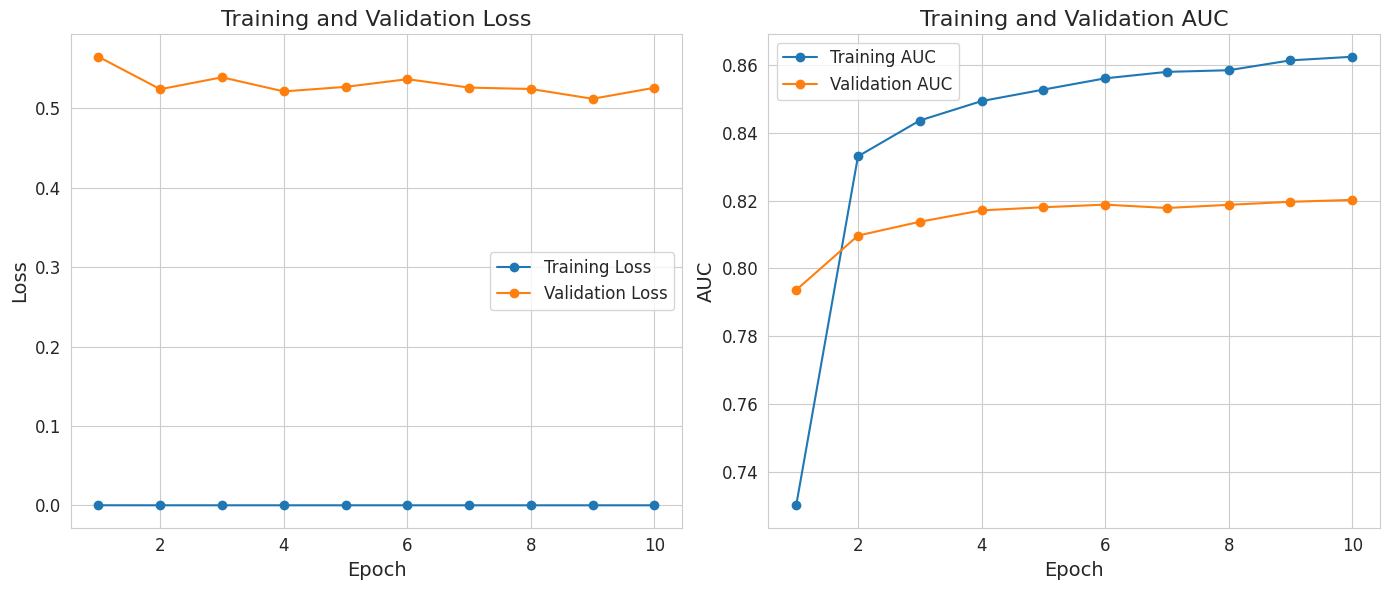

In [364]:
# Plot training history
plot_training_history(history, EPOCHS)

# Key Observations in Model Training:

1. **AUC (Area Under the Curve) Trends**:
    - **Training AUC**: The AUC for the training data continually increases over epochs. This pattern suggests that the model becomes progressively better at distinguishing between the positive and negative classes on the training data.
    - **Validation AUC**: After the 7th epoch, the AUC for the validation set stabilizes. While this can be a sign of the model's sufficient learning from the data, it's essential to monitor for potential overfitting given the continued rise in the training AUC.

2. **Loss Trends**:
    - **Training Loss**: The training loss has reached a value of 0. This implies that the model has achieved a perfect fit on the training data, which can often be a red flag for overfitting. In real-world scenarios, it's rare to achieve a zero loss without the model memorizing the training data.
    - **Validation Loss**: The fluctuation in validation loss further raises concerns about the model's stability. A model that has learned meaningful patterns should typically exhibit decreasing or stable loss values. Fluctuating loss can be indicative of model instability or the potential of oscillation around a minimum.

## Visualization of Prediction Probabilities
Understanding the distribution of prediction probabilities is crucial for understanding the behavior of a classification model. A well-calibrated model should ideally have most of its probabilities close to 0 or 1 for a binary classification task. In situations where predictions are spread out or concentrated around the 0.5 mark, it may suggest uncertainty in model decisions.

45/45 [==============================] - 0s 902us/step


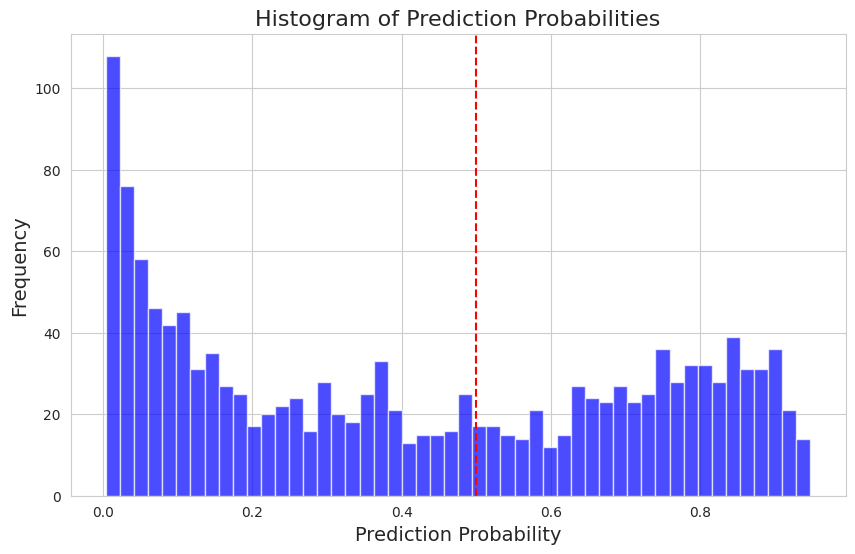

In [365]:
plot_prediction_histogram(X_test, model)

In [366]:
predictions = (model.predict(X_test) > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)
model.evaluate(X_test, y_test)

45/45 [==============================] - 0s 2ms/step
[[742 293]
 [ 85 289]]
45/45 [==============================] - 0s 1ms/step - loss: 0.5134 - auc: 0.8300


[0.513434648513794, 0.8299555778503418]

## Confusion Matrix Analysis

From the given confusion matrix, the following insights can be drawn:

### Classification Results:

- **Correct Classifications**:
  - Negative instances: 742
  - Positive instances: 289

- **Misclassifications**:
  - Negative instances classified as positive: 293
  - Positive instances classified as negative: 85

### Key Metrics:

- **Accuracy**: The formula for accuracy is \((TP + TN) / (TP + TN + FP + FN)\). For our model, this translates to:
  \((289 + 742) / (742 + 293 + 85 + 289) = 1,031 / 1,409\), which is approximately **73.15%**.

- **Precision**: The precision for the positive class is calculated as \(TP / (TP + FP)\). Our model's precision is:
  \(289 / (289 + 293)\), approximately **49.66%**. This metric highlights the proportion of positive identifications that were actually correct.

- **Recall**: The recall, or sensitivity, for the positive class is given by \(TP / (TP + FN)\). For our model, this is:
  \(289 / (289 + 85)\), which is approximately **77.28%**. This metric shows the proportion of actual positives that our model successfully identified.

From these numbers, it's evident that the model demonstrates a decent recall (**77.28%**) and a good AUC (**82.99%**) for the positive class. This suggests that the model can correctly identify a majority of the positive instances. However, the model's precision is on the lower side at **49.66%**, indicating that almost half of the instances it predicted as positive are, in fact, negative.